**Audio embeddings performance**

the following notebook is an experiment to test calculation time on different audio lenghts with all the embedding models. each embedding models expects a shape of the waveform and different sample rates, so we are going to test how this run on synthetic data wav files, and later see only the cpu load of the calculation itself and not the audio loading and preprocees.

In [ ]:
!pip install tensorflow_io
!pip install numpy==1.20.0
!pip install perfplot



     |████████████████████████████████| 22.7 MB 1.8 MB/s 
     |████████████████████████████████| 2.3 MB 36.7 MB/s 
     |████████████████████████████████| 15.3 MB 17 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.20.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 208 kB 7.2 MB/s 
     |████████████████████████████████| 51 kB 6.1 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import soundfile as sf
import os


In [ ]:

# load models from tensorflow hub
vggish_model = hub.load('https://tfhub.dev/google/vggish/1')
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
humpback_model = hub.load('https://tfhub.dev/google/humpback_whale/1')



In [ ]:
def extract_embedding_from_audio(audio_file,model):
    """Extract embeddings from one of the selected models hosted on tensorflow hub"""
    # load mono file using tensorflow
    try:
      waveform, sample_rate = tf.audio.decode_wav(tf.io.read_file(audio_file),desired_channels=1)
    
    except:
      x, sample_rate = sf.read(audio_file)
      waveform = tf.Variable(x.reshape([-1,1]),dtype=tf.float32)

    if model == 'vggish':
        waveform = tf.squeeze(waveform, axis=-1)
        #resample to 16khz
        if int(sample_rate) != 16000:
            sample_rate = tf.cast(sample_rate, dtype=tf.int64)
            waveform = tfio.audio.resample(waveform, rate_in=sample_rate, rate_out=16000)
            
        embeddings = vggish_model(waveform)
        #spectrogram,_,_,_ = plt.specgram(waveform.numpy(),Fs=16000)
        return embeddings

    elif model == 'yamnet':
        waveform = tf.squeeze(waveform, axis=-1)
        #resample to 16khz
        if int(sample_rate) != 16000:
            sample_rate = tf.cast(sample_rate, dtype=tf.int64)
            waveform = tfio.audio.resample(waveform, rate_in=sample_rate, rate_out=16000)
            
        scores, embeddings, log_mel_spectrogram = yamnet_model(waveform)
        return embeddings, log_mel_spectrogram

    elif model == 'humpback':
        if int(sample_rate) != 10000:
            sample_rate = tf.cast(sample_rate, dtype=tf.int64)
            waveform = tfio.audio.resample(waveform, rate_in=sample_rate, rate_out=10000)
        
        waveform = tf.expand_dims(waveform, 0)  # makes a batch of size 1
        pcen_spectrogram = humpback_model.front_end(waveform)
        # zero pad if lenght not a multiple of 128
        w_size = 128 # 3.84 seconds context window
        if pcen_spectrogram.shape[1] % w_size != 0:
          even_context_window = w_size - pcen_spectrogram.shape[1] % w_size
          pcen_spectrogram = tf.concat([pcen_spectrogram,tf.zeros([1,even_context_window,64])], axis=1)
        
        n_frames = int(pcen_spectrogram.shape[1]/w_size)
        
        batch_pcen_spectrogram = tf.reshape(pcen_spectrogram,shape=(n_frames,w_size,64)) 
        embeddings = humpback_model.features(batch_pcen_spectrogram)

        return embeddings, pcen_spectrogram
     
    else:
        "print model not specified"

def get_embedding(waveform,model):
    "Assumes the waveform has the correct sample rate"
    
    if model == 'vggish':
        embedding = vggish_model(waveform)
    if model == 'yamnet':
        scores, embedding, log_mel_spectrogram = yamnet_model(waveform)
    if model == 'humpback':
        
        waveform = tf.Variable(waveform.reshape([-1,1]),dtype=tf.float32)
        waveform = tf.expand_dims(waveform, 0)  # makes a batch of size 1
        pcen_spectrogram = humpback_model.front_end(waveform)
        
        # zero pad if lenght not a multiple of 128
        w_size = 128 # 3.84 seconds context window
        
        if pcen_spectrogram.shape[1] % w_size != 0:
            even_n = w_size - pcen_spectrogram.shape[1] % w_size
            pcen_spectrogram = tf.concat([pcen_spectrogram,tf.zeros([1,even_n,64])], axis=1)

        n_frames = int(pcen_spectrogram.shape[1]/w_size)

        batch_pcen_spectrogram = tf.reshape(pcen_spectrogram,shape=(n_frames,w_size,64)) 
        embedding = humpback_model.features(batch_pcen_spectrogram)
    
    return embedding


**Embedding perfomance**

Test time on different audio lenghts with all the embedding models

In [ ]:
!rm *.wav

rm: cannot remove '*.wav': No such file or directory


In [ ]:
# generate audio files that contain sinusoids with different durations
durations = [1,60,600,900] # seconds

fs_audio = 44100
f = 1000 # frequency
signals = [np.sin(2*np.pi*f*np.arange(0,dur,1/fs_audio)) for dur in durations]
filenames = []

for x,duration in zip(signals,durations):
  file = 'sinusoid_{}_{}s.wav'.format(f,duration)
  filenames.append(file)
  sf.write(file,data=x,samplerate=fs_audio)

Test first the embedding extraction directly on a signal loaded on python

Output()

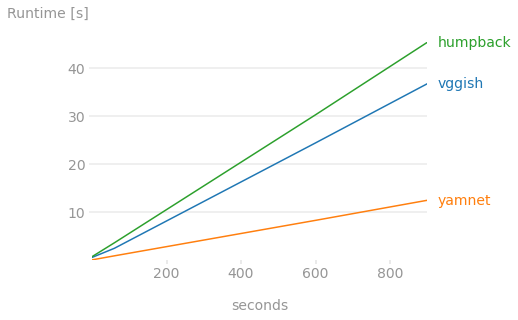

In [ ]:
import perfplot


fs = 16000 
f = 1000 # frequency

perfplot.show(
    setup=lambda n: np.sin(2*np.pi*f*np.arange(0,n,1/fs)),  # create sinusoids of n_seconds duration
    kernels=[
        lambda a: get_embedding(a,'vggish'),
        lambda a: get_embedding(a,'yamnet'),
        lambda a: get_embedding(a,'humpback'),
    ],
    labels=["vggish", "yamnet","humpback"],
    n_range=[k for k in [1,60,600,900]],
    xlabel="seconds",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    equality_check=None,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

Now test the extraction with preprocessing steps such as resampling audio loading

Output()

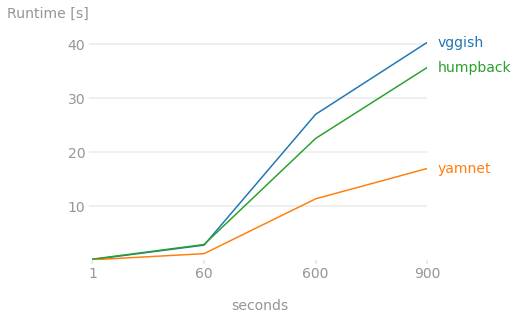

In [ ]:
import perfplot


plt.xticks([0,1,2,3],[1,60,600,900]);
perfplot.show(
    setup=lambda n: filenames[n],  # create sinusoids of n_seconds duration
    kernels=[
        lambda a: extract_embedding_from_audio(a,'vggish'),
        lambda a: extract_embedding_from_audio(a,'yamnet'),
        lambda a: extract_embedding_from_audio(a,'humpback'),
    ],
    labels=["vggish", "yamnet","humpback"],
    n_range=[k for k in [0,1,2,3]],
    xlabel="seconds",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    equality_check=None,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)
